In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))




In [11]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns;
import json
import pickle
import ast
import scipy

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.close()
    
def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def process_awake_data_return_seq_dfs(unmasked_spikes_df,chunk_time,file_path,awake_neuron_order,colors):

    seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
    seq_spikes = []
    for seq_type_ in seqs:  
        seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

    # Define the bin size (in this case, 0.2s)
    bin_size = 0.2

    seq_spike_occurance = []
    for spikes_ in seq_spikes:
        # Use the numpy.histogram function to bin the data
        hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))
        seq_spike_occurance += [list(hist)]

    seq_size_threshold= 5

    seq_event_dfs = []
    for i in range(1,7):
        print(i)

        seq_spike_count = seq_spike_occurance[i]
        # find seq start and end, defined by whetehr there were spikes or not 
        groups = return_inds_for_seq_groups(seq_spike_count)

        ### plot to check that I am accounting ofr sequences properly

        #mask
        # spikemask
        timeframe = [0,800]
        mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]

        fig,[ax1,ax2] = plt.subplots(2, 1,figsize=(10, 5))
        ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, awake_neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)
        ax2.plot(seq_spike_count, color = colors[i])
        for item in groups:
            ax2.plot(item,[-5,-5], color = 'red')

        ax1.set_xlim([0,100])
        ax2.set_xlim([0,(100/bin_size)])

        for group in groups:

            # spikemask
            timeframe = [(group[0] * bin_size)-0.5,(group[-1] * bin_size)+0.5]
            mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
            seq_mask = unmasked_spikes_df[mask].sequence_type_adjusted == i

            if len(unmasked_spikes_df[mask][seq_mask]) > seq_size_threshold:
                seq_event_dfs += [unmasked_spikes_df[mask][seq_mask]]
                
    #### save out      
    with open(file_path, 'wb') as file:
        pickle.dump(seq_event_dfs, file)
        
    return(seq_event_dfs)

def awake_seqs_find_neuron_time_occurances(awake_seq_event_dfs,seq_type):
    neuron_time_occurances = {}
    # loop across awake seq events
    for index,awake_seq in enumerate(awake_seq_event_dfs):
        if awake_seq.sequence_type.values[0] == seq_type:
            # determine relative spiek times
            relataive_ts = awake_seq.timestamp-min(awake_seq.timestamp)
            max_ts = max(relataive_ts)

            # loop across each neuron in the seq and save this data out 
            for neuron_id in awake_seq.neuron.unique():
                mask = awake_seq.neuron == neuron_id
                #mask by neuron id and determine when it occured - in relative time 
                proportional_event_time_occurance = relataive_ts[mask].values/max_ts
                if neuron_id not in neuron_time_occurances:
                    neuron_time_occurances[neuron_id] = list(proportional_event_time_occurance)
                else:
                    neuron_time_occurances[neuron_id] += list(proportional_event_time_occurance)
    return neuron_time_occurances

def sleep_seqs_find_neuron_time_occurances(replay_motif_data,seq_type):

    neuron_time_occurances ={}
    seq_type_replay_motif_data = replay_motif_data[replay_motif_data.cluster_seq_type == seq_type]
    for index, spike_times in enumerate(seq_type_replay_motif_data.cluster_spike_times):
        spike_times = np.array(ast.literal_eval(spike_times))
        cluser_ids = ast.literal_eval(seq_type_replay_motif_data.cluster_neurons[index])

        # determine relative spiek times
        relataive_ts = spike_times-min(spike_times)
        max_ts = max(relataive_ts)

        # loop across each neuron in the seq and save this data out 
        for neuron_id in np.unique(cluser_ids):
            mask = cluser_ids == neuron_id
            #mask by neuron id and determine when it occured - in relative time 
            proportional_event_time_occurance = relataive_ts[mask]/max_ts
            if neuron_id not in neuron_time_occurances:
                neuron_time_occurances[neuron_id] = list(proportional_event_time_occurance)
            else:
                neuron_time_occurances[neuron_id] += list(proportional_event_time_occurance)
    return neuron_time_occurances

yellow = '#E2DC92'
green = '#69BD9D'
blue = '#1C79B5'
red = '#BE575F'
dark_blue = '#264999'
purple = '#724F94'
gold = '#C6963E'

In [9]:
dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"

sleep_time_point_df = pd.read_csv(dat_path + 'sleep_time_points.csv')

sleep_start = {}
for index,value in enumerate(sleep_time_point_df.approx_sleep_start.values):
    mouse = sleep_time_point_df.mir.values[index]
    sleep_start[mouse] = value
    
mirs = []
for run_index,pp_file in enumerate(os.listdir(dat_path)):
# for run_index in range(1):
#     pp_file = '262_1_5_run_2106023_0729'
    
    print(run_index)
    if run_index>-1:   ### not run_index == 16 and 
        
        # set paths and other vars ################################################################################################################################
        

        if not 'sleep_time_points' in pp_file:
            mouse = '_'.join(pp_file.split('_')[0:3])
    #         if mouse in expert_mice:

            current_mouse_path = dat_path + pp_file + '\\analysis_output'
            mirs += ['_'.join(pp_file.split('_')[0:3])]
            for file in os.listdir(current_mouse_path):
                if 'chunk' in file:
                    print(file)
                    print(mouse)
                    current_sleep_start = sleep_start[mouse]
                    current_data_path = current_mouse_path + '\\' + file + '\\'
                    chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')

                    if chunk_time[0] > current_sleep_start:
                        replay_motif_data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
                        reactivations_found = len(replay_motif_data)
                        mins = np.diff(chunk_time)[0]/60
                    else:
                        replay_motif_data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
                        post_sleep_mask = replay_motif_data.first_spike_time > (current_sleep_start - chunk_time[0] )
                        replay_motif_data = replay_motif_data[post_sleep_mask]
                        reactivations_found = len(replay_motif_data)
                        mins = np.diff(chunk_time)[0]/60

                    out_path = current_data_path + 'temporal_structure_analysis\\'

                    ## load awake data #################################################################################################################################
                    

                    awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"

                    for file_ in os.listdir(awake_PP_path):
                        if mouse in file_:
                            awake_file = file_

                    #### load in awake task data dn determine awake sequence ordering:

                    with open(awake_PP_path + awake_file + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
                        unmasked_spikes_df = pickle.load(handle)

                    with open(awake_PP_path + awake_file + r'\analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
                        awake_neuron_order = pickle.load(handle)


                    ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')

                    neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')

                    colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')

                    spikes_df = unmasked_spikes_df

                    colors += ['pink','lightblue', 'k'] 

                    #### process/load processed awake data 

                    if not os.path.isdir(current_data_path + 'temporal_structure_analysis\\'):
                        os.mkdir(current_data_path + 'temporal_structure_analysis\\')

                    file_path = current_data_path + 'temporal_structure_analysis\\' + 'awake_seq_event_dfs.pkl'
                    if not os.path.isfile(file_path):
                        print('processing')
                        awake_seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,chunk_time,file_path,awake_neuron_order,colors)
                    else:
                        with open(file_path, 'rb') as file:
                            awake_seq_event_dfs = pickle.load(file)
                            print('loading')

                    # determine how mnay events occured in awake 
                    awake_seq_events = {}
                    for awake_seq in awake_seq_event_dfs:
                        type_ = awake_seq.sequence_type.values[0]

                        if type_ not in awake_seq_events:
                            awake_seq_events[type_] = 0
                        else:
                            awake_seq_events[type_] += 1
                            
                            
    break
                            
                            
                            

0
chunk1_8700to9300
136_1_3
loading
chunk2_10000to11600
136_1_3
loading
chunk3_11900to12500
136_1_3
loading


1
2
3
4
5
6


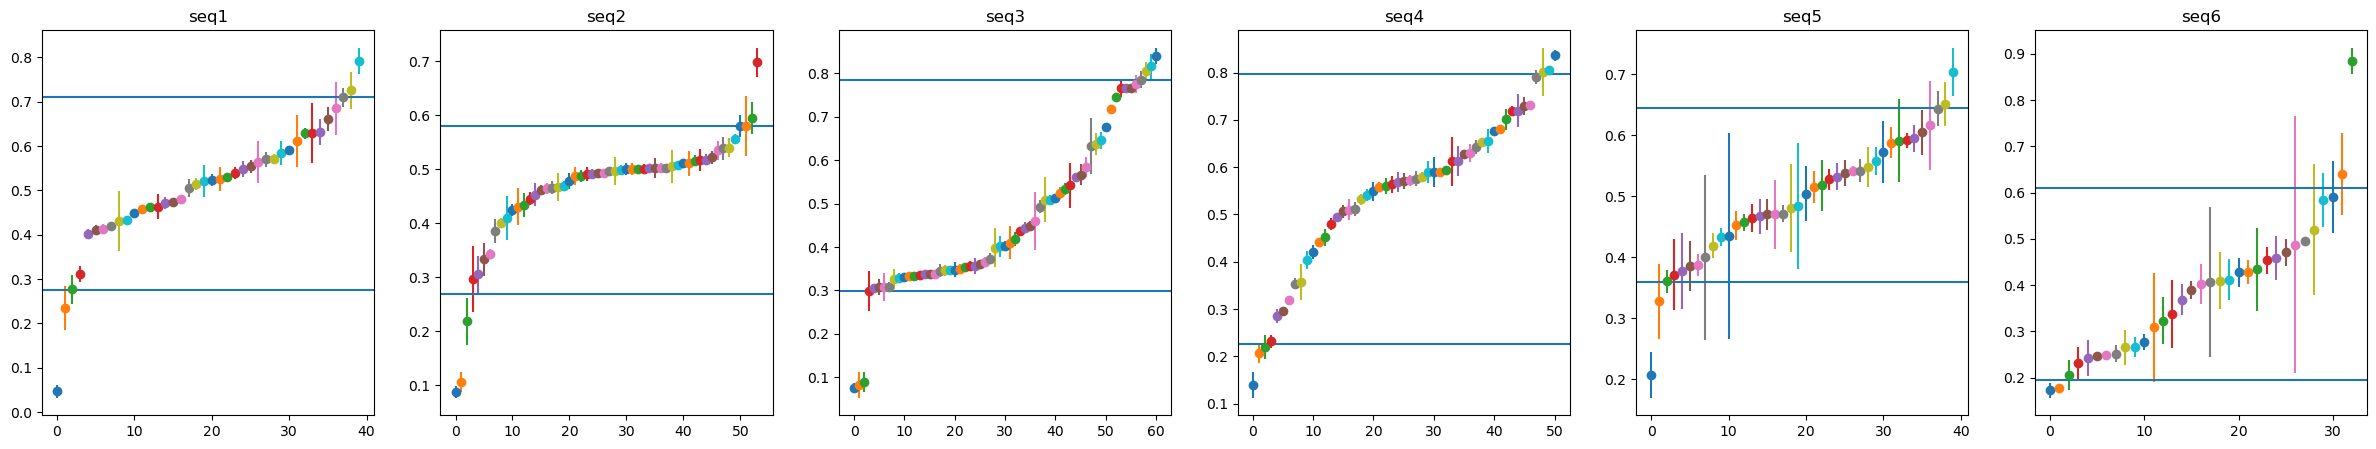

In [13]:
## for each seq event detemine the average position of each neuron (av spike time relative to length of motif). 
#I only take awake neurons that occur in at least 5% of awake seqs and I exclude neurons that tend fire at the very edges of the motifs (the first and last (top and bottom) 5% of neurons)
all_awake_mean_motif_lengths= []
all_awake_neruon_ref_df = []
fig, ax = plt.subplots(1,6, figsize=(5*6,5))
for seq_type in range(1,7):
    print(seq_type)

    event_length = []
    for awake_seq in awake_seq_event_dfs:
        if awake_seq.sequence_type.values[0] == seq_type:
            event_length += [max(awake_seq.timestamp) - min(awake_seq.timestamp)]
    awake_mean_motif_length = np.mean(event_length)

    neuron_time_occurances = awake_seqs_find_neuron_time_occurances(awake_seq_event_dfs,seq_type)

    dat = []
    err = []
    neuron_ids = []
    for neuron_id in neuron_time_occurances:
        # if it is in at least 10% of seqs
        if len(neuron_time_occurances[neuron_id]) > int(awake_seq_events[seq_type]*0.05):
            neuron_ids += [neuron_id]
            dat +=[np.mean(neuron_time_occurances[neuron_id])]
            err += [scipy.stats.sem(neuron_time_occurances[neuron_id])]


    sorting_index = np.argsort(dat)
    x = list(range(0,len(dat)))
    for i in range(len(x)):
        ax[seq_type-1].errorbar(x[i],np.array(dat)[sorting_index][i], yerr=np.array(err)[sorting_index][i], fmt='o')

    ax[seq_type-1].axhline(np.percentile(dat, 95) )
    ax[seq_type-1].axhline(np.percentile(dat, 5) )
    ax[seq_type-1].set_title('seq' + str(seq_type))

    # filter out top and bottom 5%
    filtered_dat = []
    filtered_neuron_ids = []
    for index,item in enumerate(dat):
        if item > np.percentile(dat, 10) and item < np.percentile(dat, 90):
            filtered_dat += [item]
            filtered_neuron_ids += [neuron_ids[index]]

    # mak eit relative again
    rel_filtered_dat = np.array(filtered_dat) - min(filtered_dat)
    rel_filtered_dat = rel_filtered_dat/ max(rel_filtered_dat)


#     # also do this for mean length as this wlll change also 
    awake_mean_motif_length = (max(filtered_dat) - min(filtered_dat)) * awake_mean_motif_length
    all_awake_mean_motif_lengths += [awake_mean_motif_length]

    sorting_index = np.argsort(filtered_dat)
    awake_neuron_order = np.array(filtered_neuron_ids)[sorting_index]
    awake_neruon_ref_df = pd.DataFrame({'neuron_id' : awake_neuron_order, 'relative_occurance_time' : np.array(rel_filtered_dat)[sorting_index]})

    all_awake_neruon_ref_df += [awake_neruon_ref_df]


# SaveFig('seq_neuron_time_offset_filtering.png',out_path)


with open(out_path+'awake_seq_neuron_position_ref_dfs', 'wb') as f:
    pickle.dump(all_awake_neruon_ref_df, f)

In [ ]:
## should this be relative temporal position or relative neuron-to-neuron position? 

1
skip
2
3
skip
skip
skip
4
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
5
skip
skip
skip
skip
skip
skip
skip
6


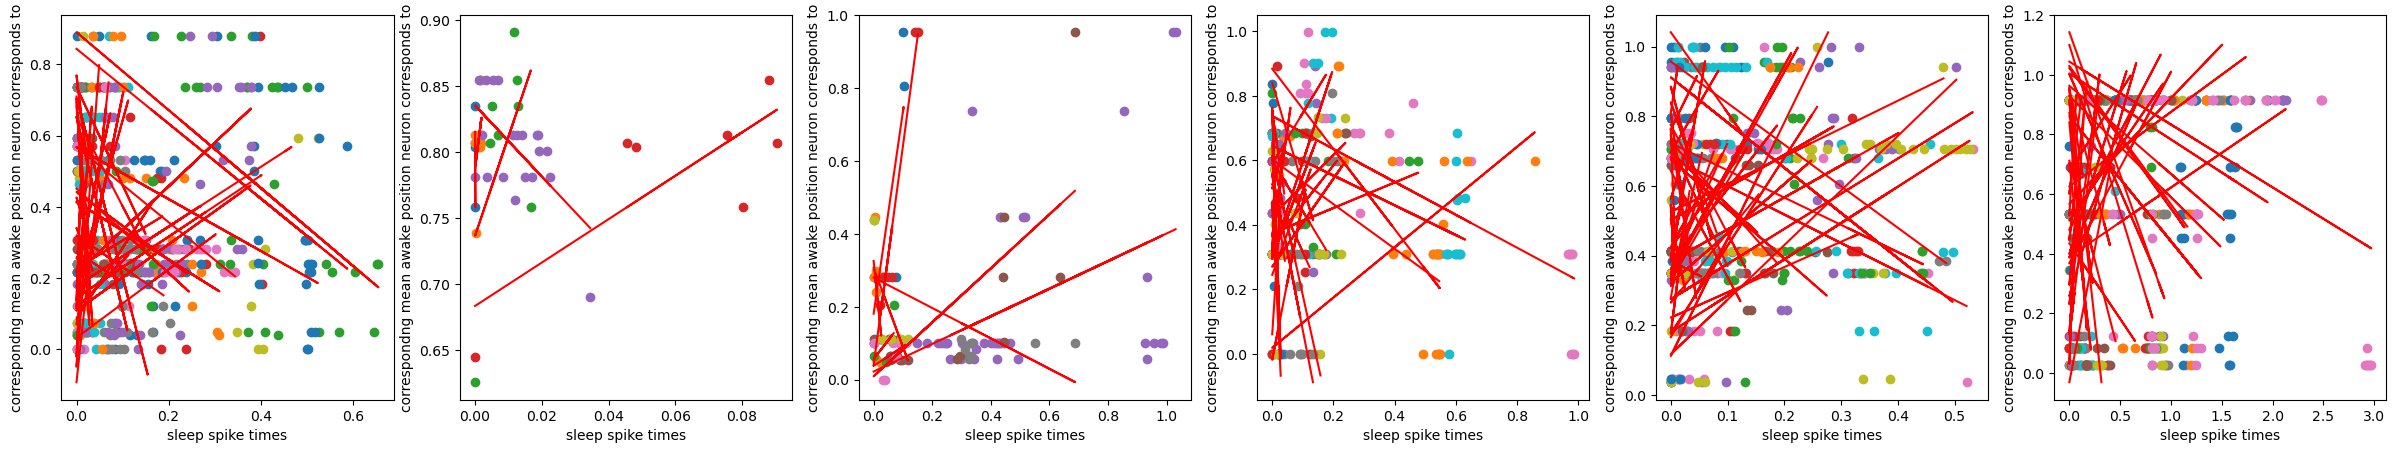

In [16]:
#################################################################################################################################


### describe what is happening for future emmett! 
# here for each replay event I take the relative event spike times and find the regression line  against the corresponding av awake time (relative awake time) for each neuron.
## for each regression check first if it has a reasonbly good correlation (r value > 0.5):
## then check if the slope is slopey enough (slope steeper than 4x less steep than av. awake)
## this means it has temporal order
# if not these then check if it has a reasonbly good r2 correlation (the line fits the data well) (r2 value > 0.5) 
# and a flat slope (slope less steep than 4x less steep  av. awake)
# this means it is stationsary 
# other wise put it in misordered/ other (could be a mixture of frward and backward or something)

# otherwsie put it in misordered/ other
from scipy.stats import linregress 

regression_df = pd.DataFrame({})
stationary_regression_df = pd.DataFrame({})
fragmented_regression_df = pd.DataFrame({})

fig, ax = plt.subplots(1,6, figsize=(5*6,5))
non_significants = []
significants = []
sig_stationaries = []
skipped_ID = []
for seq_type in range(1,7):
    print(seq_type)
    awake_neruon_ref_df = all_awake_neruon_ref_df[seq_type-1]

    seq_type_replay_motif_data = replay_motif_data[replay_motif_data.cluster_seq_type == seq_type].reset_index()

    regression_line = []
    x_vals = []
    y_vals = []
    event_lengths = []
    slopes = []
    r_values = []
    reactivation_ID = []
    non_significant = 0
    stationary = 0

    stationar_regression_line = []
    stationary_x_vals = []
    stationary_y_vals = []
    stationary_reactivation_ID = []
    stationary_slopes = []

    other_x_vals = []
    other_y_vals = []
    other_regression_line = []
    other_reactivation_ID = []

    for index_, spike_times in enumerate(seq_type_replay_motif_data.cluster_spike_times):

            spike_times = np.array(ast.literal_eval(spike_times))
            cluser_ids = ast.literal_eval(seq_type_replay_motif_data.cluster_neurons[index_])

            # filter so only spikes that are in awake are considered:
            filt_cluser_ids = []
            filt_spike_times = []
            for index,id_ in enumerate(cluser_ids):
                if id_ in awake_neruon_ref_df.neuron_id.values:
                    filt_cluser_ids +=[id_]
                    filt_spike_times += [spike_times[index]]

            if len(filt_spike_times) > 3:

                # make them all relative again (getting rid of some values may ahve changed this)
                filt_rel_spike_times = filt_spike_times - min(filt_spike_times)
                event_length = max(filt_rel_spike_times)



                awake_rel_occurance_times = []
                for cluser_id in filt_cluser_ids:
                    awake_rel_occurance_times += [awake_neruon_ref_df[awake_neruon_ref_df.neuron_id == cluser_id].relative_occurance_time.values[0]]

                try:
                    x = np.array(filt_rel_spike_times)
                    y = np.array(awake_rel_occurance_times)
                    # Perform linear regression
                    slope, intercept, r_value, p_value, std_err = linregress(x, y)


                    awake_mean_motif_length = all_awake_mean_motif_lengths[int(seq_type-1)]
                    ref_slope = 1/awake_mean_motif_length
                    if abs(r_value) > 0.4 and abs(slope) > (ref_slope/5):  
                            # temporally ordered events
                            # Generate the regression line
                            regression_line += [slope * x + intercept]
                            # x valea re actual spike times (realtive to replay event onset)
                            x_vals += [x]
                            event_lengths += [event_length]
                            # not sure thse are useful, they essentially correspond to how complete the event was 
                            slopes += [slope]
                            r_values += [r_value]
                            reactivation_ID+=[seq_type_replay_motif_data['index'][index_]]
                            y_vals += [y]

                            ax[seq_type-1].scatter(x, y, label='Data Points')
                            ax[seq_type-1].plot(x, slope * x + intercept, color='red', label='Regression Line')
                            ax[seq_type-1].set_xlabel('sleep spike times')
                            ax[seq_type-1].set_ylabel('correspondng mean awake position neuron corresponds to')




                    elif (r_value**2) > 0.5 and abs(slope) < (ref_slope/5):
                            stationar_regression_line += [slope * x + intercept]
                            stationary_x_vals += [x]
                            stationary_y_vals += [y]
                            stationary_reactivation_ID += [seq_type_replay_motif_data['index'][index_]]
                            stationary_slopes += [slope]
                            stationary += 1



                    else:
                            non_significant += 1
                            other_x_vals += [x]
                            other_y_vals += [y]
                            other_regression_line += [slope * x + intercept]
                            other_reactivation_ID += [seq_type_replay_motif_data['index'][index_]]


                except:
                    print('skipped-for some error')
            else:
                print('skip')
                skipped_ID += [seq_type_replay_motif_data['index'][index_]]






    if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
        task_involved = [1] * len(reactivation_ID)
    else:
        task_involved = [0] * len(reactivation_ID)

    df = pd.DataFrame({'seq_type' : [seq_type]*len(slopes), 'regression_line' :regression_line,'filt_rel_spike_times' :x_vals,'awake_rel_occurance_times':y_vals,'slope' :slopes, 'reactivation_ID': reactivation_ID,'task_involved': task_involved})
    non_significants += [non_significant]
    significants += [len(regression_line)]
    sig_stationaries += [stationary]

    regression_df = pd.concat([regression_df, df], axis=0)

    if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
        task_involved = [1] * len(stationary_reactivation_ID)
    else:
        task_involved = [0] * len(stationary_reactivation_ID)

    stat_df = pd.DataFrame({'seq_type' : [seq_type]*len(stationary_slopes), 'regression_line' :stationar_regression_line,'filt_rel_spike_times' :stationary_x_vals,'awake_rel_occurance_times':stationary_y_vals,'slope' :stationary_slopes, 'reactivation_ID': stationary_reactivation_ID,'task_involved': task_involved})
    stationary_regression_df = pd.concat([stationary_regression_df, stat_df], axis=0)


    if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
        task_involved = [1] * len(other_reactivation_ID)
    else:
        task_involved = [0] * len(other_reactivation_ID)

    frag_df = pd.DataFrame({'seq_type' : [seq_type]*len(other_x_vals), 'regression_line' :other_regression_line,'filt_rel_spike_times' :other_x_vals,'awake_rel_occurance_times':other_y_vals, 'reactivation_ID': other_reactivation_ID,'task_involved': task_involved})
    fragmented_regression_df = pd.concat([fragmented_regression_df, frag_df], axis=0)

regression_df = regression_df.reset_index(drop = True)
stationary_regression_df = stationary_regression_df.reset_index(drop = True)
fragmented_regression_df = fragmented_regression_df.reset_index(drop = True)

# SaveFig('replay_temporal_progression_regression_lines.png',out_path)
#                     regression_df.to_csv(out_path + 'regression_df.csv')
#                     stationary_regression_df.to_csv(out_path + 'stationary_regression_df.csv')
fragmented_regression_df.to_csv(out_path + 'fragmented_regression_df.csv')



# update motif data with catagorisations

catagory = []
IDs = []
catagory += (['sequential']*len(regression_df.reactivation_ID.values))
IDs += list(regression_df.reactivation_ID.values)
catagory += (['stationary']*len(stationary_regression_df.reactivation_ID.values))
IDs += list(stationary_regression_df.reactivation_ID.values)
catagory += (['fragmented']*len(fragmented_regression_df.reactivation_ID.values))
IDs += list(fragmented_regression_df.reactivation_ID.values)

final_catagory = []
counter = 0
for i in range(len(replay_motif_data)):
    if not i in sorted(IDs):
        final_catagory += [np.nan]
    else:
        final_catagory += [np.array(catagory)[np.argsort(IDs)][counter]]
        counter += 1

replay_motif_data['ordering_classification'] = final_catagory


# save this out: 
replay_motif_data.to_csv(current_data_path + 'filtered_replay_clusters_df.csv')

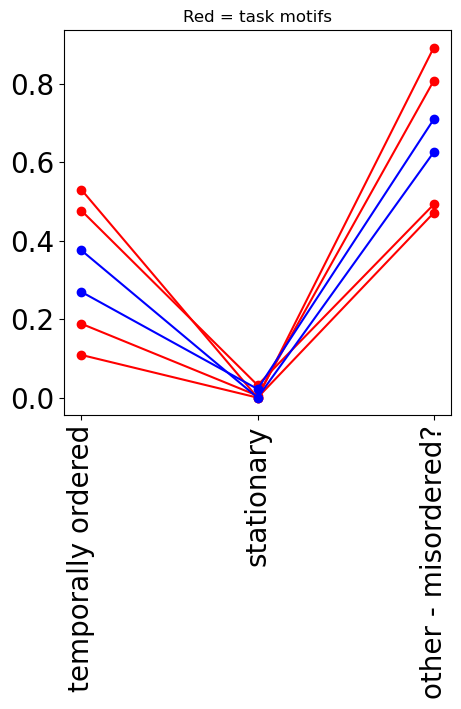

In [17]:
#################################################################################################################################
total = np.array(significants) + np.array(sig_stationaries)+ np.array(non_significants) 
t_involve = []
fig,ax = plt.subplots(1, 1,figsize=(5, 5))
for i in range(len(np.array(significants)/total)):
    if i in np.load(current_data_path+'task_order_seqs.npy'):
        c_ = 'red'
        t_involve += [1]
    else:
        c_ = 'blue'
        t_involve += [0]

    ax.plot([0,1,2],[(np.array(significants)/total)[i],(np.array(sig_stationaries)/total)[i],(np.array(non_significants)/total)[i]],'-o', color = c_)

labels = ['temporally ordered','stationary','other - misordered?']

ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Red = task motifs')

df = pd.DataFrame({'seq_type' : range(1,7), 'temporally_ordered' :(np.array(significants)/total),'stationary':(np.array(sig_stationaries)/total),'not_ordered' :(np.array(non_significants)/total),'task_involved' :t_involve })

# SaveFig('temporally_ordered_proportions.png',out_path)
df.to_csv(out_path + 'temporally_ordered_proportions.csv')
                    